#### Import requiring libraries

In [66]:
%matplotlib inline

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch,torchvision,torchmetrics
from tqdm import tqdm
import tkinter as tk
from PIL import Image
import gradio

#### Loading and preprocessing the dataset

In [68]:
batch_size=60
#Initialize the number of samples used
#for both training and testing

train_dataset = torchvision.datasets.MNIST(root="dataset/",download=True,train=True,transform=torchvision.transforms.ToTensor())
#we convert the data into tensors via
# .ToTensor()

train_size=int(.8*len(train_dataset))
value_size=len(train_dataset)-train_size


#Splitting the dataset by following the 80/20 rule
train_subset,value_subset=torch.utils.data.random_split(train_dataset,[train_size,value_size])


train_loader = torch.utils.data.DataLoader(dataset=train_subset,batch_size=batch_size,shuffle=True)
value_loader = torch.utils.data.DataLoader(dataset=value_subset,batch_size=batch_size,shuffle=True)

# `DataLoader` creates an iterable over
#the training set

# `shuffle` will randomize the data
#at each epoch, which will help
#improving the model

test_dataset = torchvision.datasets.MNIST(root="dataset/",download=True,train=False,transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)


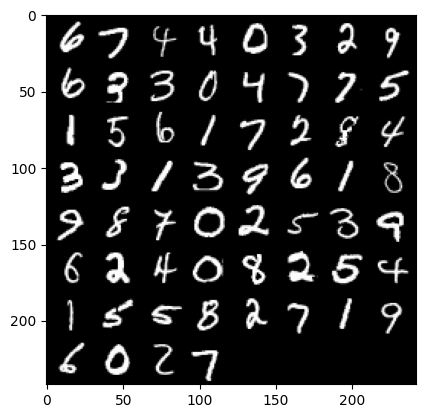

In [69]:
def show_image(image):
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image,(1,2,0)))
    plt.show()
# image.numy() will convert the tensor into a numpy array
# np.transpose(np_image,(1,2,0)) will rearrange the pic
#format, so it will be compatible with matplotlib,
#which requires : (height,width,channels) --> (1,2,0)

data_iter = iter(train_loader)
images,labels = next(data_iter)

show_image(torchvision.utils.make_grid(images))




### Defining the CNN architecture

In [70]:
class CNN(torch.nn.Module):
    def __init__(self,in_channels,nbr_classes):
        super(CNN,self).__init__()

        # 1st 2D convolutional layer with 8 filters/different features
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=3,padding=1)
        
        # Max pooling layer
        self.pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # 2nd 2D convolutional layer
        self.conv2 = torch.nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1)

        # The dropout will "turn off" random neurons
        #in order to avoid overfitting
        self.dropout=torch.nn.Dropout(0,5)

        # Fully connected layer
        self.fc1 = torch.nn.Linear(16*7*7,nbr_classes)
    def forward(self,x):
        # Apply first convolution and ReLU
        x = torch.nn.functional.relu(self.conv1(x))

        # Apply Max Pooling
        x = self.pool(x)

        # Apply second convolution and ReLU
        x = torch.nn.functional.relu(self.conv2(x))

        # Apply second Max Pooling
        x = self.pool(x)

        # Flatten (Reshape) the tensors from 2D to 1D
        x = x.reshape(x.shape[0],-1)

        x = self.dropout(x)

        # Apply fully connected layer
        x = self.fc1(x)
        return x


device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN(in_channels=1,nbr_classes=10).to(device)
print(model)



CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0, inplace=5)
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


### Training the CNN model

In [71]:
# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define optimizer function
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

#### Evaluate the model

In [72]:
acc = torchmetrics.Accuracy(task="multiclass",num_classes=10)
precision = torchmetrics.Precision(task="multiclass",num_classes=10)
recall = torchmetrics.Recall(task="multiclass",num_classes=10)


epochs = 10

train_losses=[]
val_losses=[]

for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")

    model.train()
    batch_losses=[]

    for batch_index, (data,targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data)
        loss = loss_fn(scores,targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
    train_losses.append(sum(batch_losses)/len(batch_losses))

    model.eval()
    val_batch_loss=[]
    all_preds=[]
    all_labels=[]
    with torch.no_grad():
        for images, labels in value_loader:
            output=model(images)
            _,preds=torch.max(output,1)
            #Unpack the torch.max in order to obtain tensors, not tuples
            acc.update(preds,labels)
            precision.update(preds,labels)
            recall.update(preds,labels)
            val_loss=loss_fn(output,labels)
            val_batch_loss.append(val_loss.item())


    val_losses.append(sum(val_batch_loss)/len(val_batch_loss))

test_accuracy=acc.compute()

print(f"Test Accuracy: {round(float(test_accuracy),3)*100}%")


Epoch [1/20]


100%|██████████| 800/800 [00:06<00:00, 131.06it/s]


Epoch [2/20]


100%|██████████| 800/800 [00:06<00:00, 117.38it/s]


Epoch [3/20]


100%|██████████| 800/800 [00:07<00:00, 113.21it/s]


Epoch [4/20]


100%|██████████| 800/800 [00:06<00:00, 114.51it/s]


Epoch [5/20]


100%|██████████| 800/800 [00:06<00:00, 130.68it/s]


Epoch [6/20]


100%|██████████| 800/800 [00:06<00:00, 116.74it/s]


Epoch [7/20]


100%|██████████| 800/800 [00:08<00:00, 95.82it/s] 


Epoch [8/20]


100%|██████████| 800/800 [00:08<00:00, 89.54it/s]


Epoch [9/20]


100%|██████████| 800/800 [00:07<00:00, 109.70it/s]


Epoch [10/20]


100%|██████████| 800/800 [00:07<00:00, 107.07it/s]


Epoch [11/20]


100%|██████████| 800/800 [00:08<00:00, 88.89it/s] 


Epoch [12/20]


100%|██████████| 800/800 [00:08<00:00, 92.51it/s]


Epoch [13/20]


100%|██████████| 800/800 [00:08<00:00, 94.06it/s]


Epoch [14/20]


100%|██████████| 800/800 [00:08<00:00, 93.88it/s]


Epoch [15/20]


100%|██████████| 800/800 [00:08<00:00, 93.62it/s]


Epoch [16/20]


100%|██████████| 800/800 [00:08<00:00, 92.78it/s]


Epoch [17/20]


100%|██████████| 800/800 [00:08<00:00, 95.75it/s]


Epoch [18/20]


100%|██████████| 800/800 [00:08<00:00, 94.90it/s] 


Epoch [19/20]


100%|██████████| 800/800 [00:08<00:00, 94.08it/s] 


Epoch [20/20]


100%|██████████| 800/800 [00:08<00:00, 92.59it/s]


Test Accuracy: 98.2%


#### Visualize the model's performance

#### Training and Validation Loss Plot

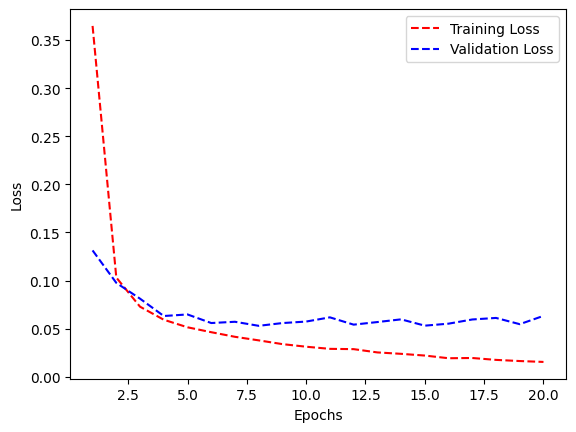

In [73]:
nbr_epochs=range(1,len(train_losses)+1)


plt.plot(nbr_epochs,train_losses,'r--',label='Training Loss')
plt.plot(nbr_epochs,val_losses,'b--',label='Validation Loss')
plt.legend()
#plt.title('Training Loss for CNN')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

#### Confusion Matrix

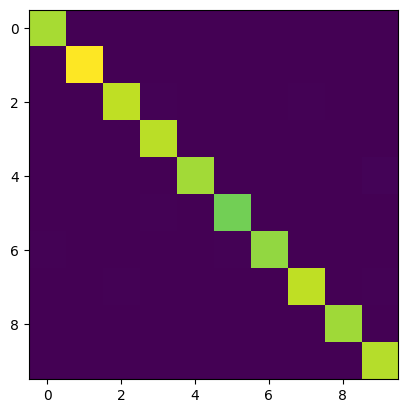

In [74]:
model.eval()
all_preds,all_labels=[],[]
with torch.no_grad():
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _,preds=torch.max(output,1)

        if device == "cpu":
            all_preds.append(preds)
            all_labels.append(labels)
        elif device == "cuda":
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
        else:
            raise ValueError(f"Unsuported device: {device}. Expected 'cpu' or 'gpu'.")
all_preds=torch.cat(all_preds)
all_labels=torch.cat(all_labels)


cm=torchmetrics.ConfusionMatrix(task='multiclass',num_classes=10)
confusion_matrix=cm(all_preds,all_labels)
plt.imshow(confusion_matrix)

#### Create the web interface and load the model

In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model=CNN(in_channels=1,nbr_classes=10).to(device)
model.eval()

def predict(image):
    if image is None:
        return "Please draw a number !"
    if isinstance(image,dict):
        image=image['composite']
    image = Image.fromarray(image.astype('uint8')).convert('L').resize((28,28))
    image_array = np.array(image)/255.0

    image_array=1.0-image_array

    image_tensor=torch.from_numpy(image_array).float().unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        output=model(image_tensor)
        _,prediction=torch.max(output,1)
    return f"Predicted: {np.argmax(prediction.item())}"
    
    

test = gradio.Interface(
    fn=predict,
    inputs=gradio.Sketchpad(),
    outputs="text"
)


test.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
